In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange


from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, get_trajs, speed_windowed, theta_windowed

show_verb = True
save_verb = True
anim_show_verb = False

In [2]:
rawTrajs = pd.read_parquet("../data/tracking/pre_merge_tracking.parquet")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle != red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle == red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")


# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")


# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


In [3]:
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
v = np.array(redTraj[0].v)
print(v.shape)

(32000, 2)


In [4]:
print(np.std(np.array(v), axis = 0))

[22.77689314 23.75942747]


In [13]:
v1, v2 = v[:], v[:]
v1.shape

(32000, 2)

In [28]:
"""vacf = np.empty(10)
for lag_ in range(10):
    if lag_ == 0: v1, v2 = np.linalg.norm(v[:], axis=1), np.linalg.norm(v[:], axis=1)
    else: v1, v2 = np.linalg.norm(v[:-lag_], axis=1), np.linalg.norm(v[lag_:], axis=1)
    v1v2 = (v1 - np.mean(v1)) * (v2 - np.mean(v2))
    vacf[lag_] = np.mean(v1v2)
"""
vacf2 = np.empty(10)
for lag_ in range(10):
    if lag_ == 0: v1, v2 = v[:], v[:]
    else: v1, v2 = v[:-lag_], v[lag_:]
    v1v2 = (v1 - v1.mean(axis=0)) * (v2 - v2.mean(axis=0))
    # Dot product for a given lag time
    v1_dot_v2 = np.sum(v1v2, axis=1)

    # Averaging over a single realization
    vacf2[lag_] = np.mean(v1_dot_v2)

In [36]:
print(sum(np.var(v, axis=0)))
print(vacf2[0])

1083.2972547140344
1083.2972547140346


In [3]:
COORDS = np.array(rawTrajs.loc[:,["x","y"]])
hist_bins = np.linspace(0, np.pi, 10)

theta = np.zeros((nFrames, nDrops))
theta_hist = np.zeros((nFrames, len(hist_bins)-1))

for frame in tqdm(range(nFrames)):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    # find the 2 nearest neighbors, 3 since it counts itself
    _, n = kd.query(coords, 3)
    # remove self from neighbors
    n = np.array(n)[:, 1:]
    # displacement vectors
    r_j = coords[n[:, 0]] - coords
    r_k = coords[n[:, 1]] - coords
    # angle between the two vectors

    scalar_prod = np.zeros(nDrops)
    for i in range(nDrops):
        scalar_prod[i] = np.dot(r_j[i], r_k[i])

    if np.count_nonzero(scalar_prod) != nDrops:
        print("scalar_prod has zeros")
    theta[frame] = np.arccos(scalar_prod / (np.linalg.norm(r_j, axis=1) * np.linalg.norm(r_k, axis=1))) 
    theta_hist[frame], _ = np.histogram(theta[frame], bins=hist_bins, density=True)

100%|██████████| 32000/32000 [00:13<00:00, 2454.70it/s]


09:56:15 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
09:56:15 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 120 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/3body/3body_wind_raw.mp4


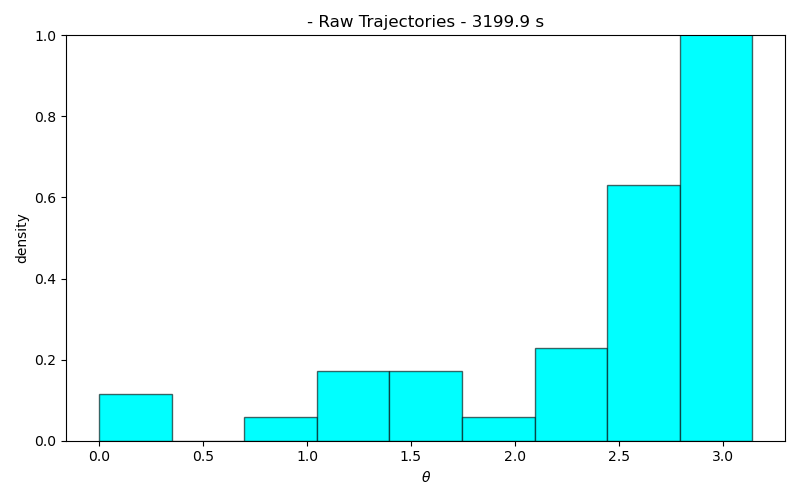

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container):
    def animate(frame):
        title.set_text(f"- Raw Trajectories - {frame/10} s")
        
        n, _ = np.histogram(theta[frame], hist_bins, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
            
        return bar_container.patches
    return animate

_, _, bar_container = ax.hist(theta[0], hist_bins, **default_kwargs_blue, label="blue particles")
title = ax.set_title("- Raw Trajectories - 0 s")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel("density")
ax.set_ylim(0, 1)
plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container), nFrames, repeat=False, blit=False)
if save_verb:
    ani.save('../results/3body/3body_wind_raw.mp4', fps=120, extra_args=['-vcodec', 'libx264'])
plt.show()

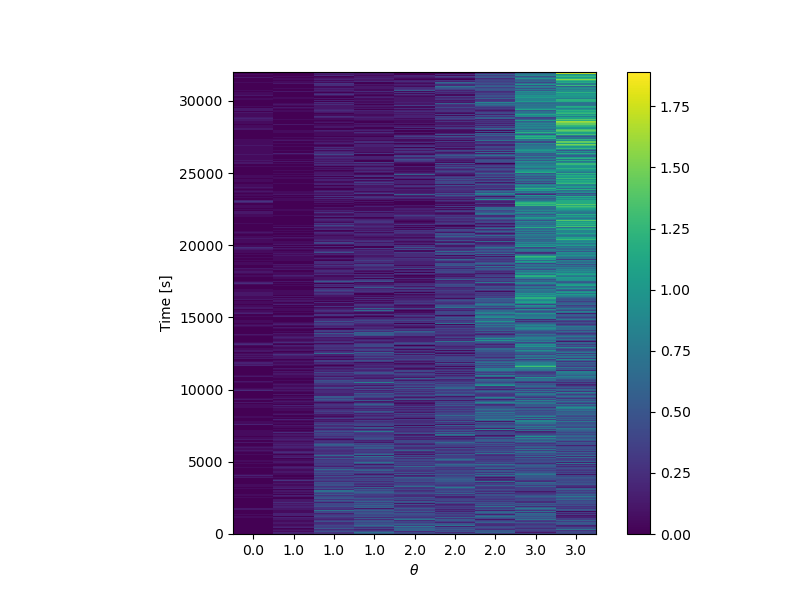

In [ ]:
X, Y = np.meshgrid(hist_bins[:-1] + np.diff(hist_bins) / 2, np.linspace(0, nFrames, nFrames))

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
img = ax.pcolormesh(X, Y, theta_hist, cmap="viridis", shading="auto")
fig.colorbar(img)
ax.set_xlabel(r"$\theta$")
ax.set_ylabel("Time [s]")
ax.set_xticks(hist_bins[:-1] + np.diff(hist_bins) / 2)
ax.set_xticklabels(np.round(hist_bins[:-1] + np.diff(hist_bins) / 2))
ax.set_aspect(1/8000)
plt.ylabel("Time [s]")
plt.show()